# Shors Algorithm


Shor's Algorithm is known for factoring numbers in polynomial time. Since RSA works on the principle that its impossible to factor large integers, this algorithm can be used to break RSA on a quantum computer given enough qubits to work on( which is still under development )

An ideal Quantum computer with 4099 stable bits can break RSA within 10 seconds, but this is an ideal case and such a computer doesnt exist

A paper published by Craig Gidney from Google and Martin Ekera from the Royal Institute of Technology showed that using 20 million noisy qubits, it would take upto 8 hours to crack RSA. In our current scenario the biggest quantum computer has only 72 qubits.
So it is going to take another decade or maybe two decades to acheive that much computing power

This notebook shows/ simulates the Shor's Algorithm for factoring 15

The Algorithm works on the fact that factor finding problem can be made into a period finding problem and solve in polynomial time. A periodic function can be of the form:
$$
    a^{r} mod N = 1
$$
<br>
where r is the period

In [9]:
# Importing Modules

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
%matplotlib inline


The function c_amod15 returns us a controlled - U gate for value 'a', repeated _power_ times

In [5]:
def c_amod15(a, power):
  if a not in [2,7,8,11,13]:
    raise ValueError("test")
  U = QuantumCircuit(4)
  for iteration in range(power):
    if a in [2,13]:
      U.swap(0,1)
      U.swap(1,2)
      U.swap(2,3)
    if a in [7,8]:
      U.swap(2,3)
      U.swap(1,2)
      U.swap(0,1)
    
    if a == 11:
      U.swap(2,3)
      U.swap(0,2)

    if a in [7,11,13]:
      for q in range(4):
        U.x(q)
  U = U.to_gate()
  U.name = "%i^%i mod 15" %(a,power)
  c_U = U.control()
  return c_U

#### Setting the number of counting qubits and setting value of a


In [6]:
n_count = 8
a = 7

## Fourier transform function

In [7]:
def qft_dagger(n):
  qc = QuantumCircuit(n)

  for qubit in range(n//2):
    qc.swap(qubit, n-qubit-1)
  
  for j in range(n):
    for m in range(j):
      qc.cp(-np.pi/float(2**(j-m)),m,j)
    qc.h(j)
  qc.name = "QFT"
  return qc

## Drawing the Quantum circuit

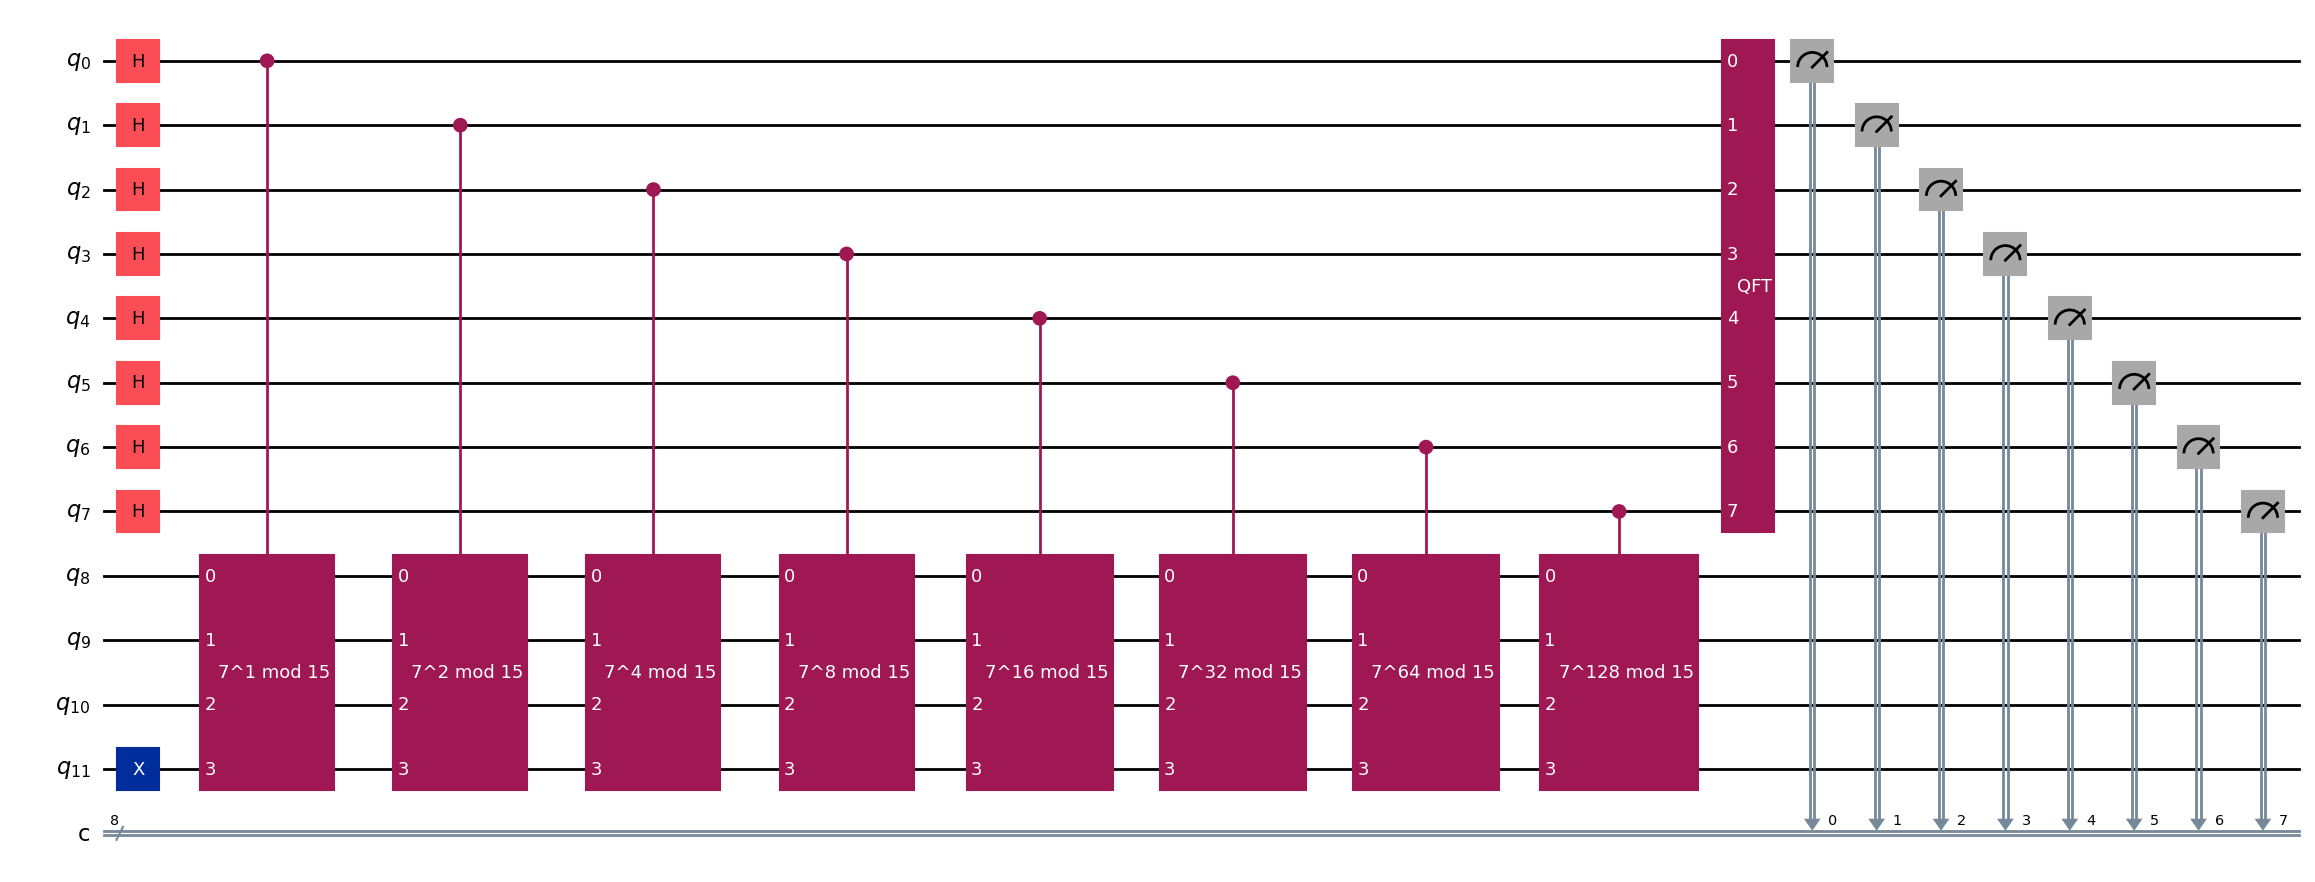

In [8]:
qc = QuantumCircuit(n_count+4, n_count)

for q in range(n_count):
  qc.h(q)

qc.x(3+n_count)


for q in range(n_count):
  qc.append(c_amod15(a,2**q), [q] + [i+n_count for i in range(4)])



qc.append(qft_dagger(n_count), range(n_count))


qc.measure(range(n_count), range(n_count))

qc.draw(fold = -1)
circuit_drawer(qc,output = 'mpl', filename = 'circuit.png',fold = -1)

### Measuring Results from classical register

In [38]:


# Set up Aer simulator backend
#aer_sim = Aer.get_backend('aer_simulator')

aer_sim = AerSimulator()

#circuit
t_qc = transpile(qc,aer_sim)
# ---> If you want to look the circuit ! <-----------
# launch :          t_qc.draw('mpl', style="iqp")


Measurement outcomes: {'00000000': 254, '10000000': 263, '11000000': 232, '01000000': 275}


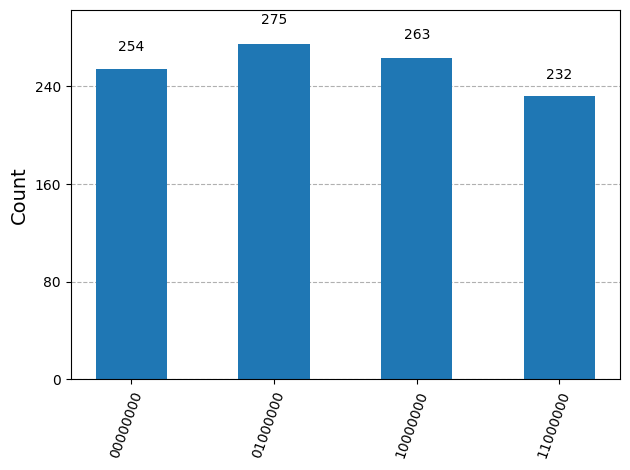

In [28]:
#job
q_obj = aer_sim.run(t_qc)
results = q_obj.result()
counts = results.get_counts()
print("Measurement outcomes:", counts)
plot_histogram(counts)


Since the measured values are in binary, we convert to decimal values and also find the corresponding phases

In [20]:
rows, measured_phases = [], []

for output in counts:
  decimal = int(output, 2)
  phase = decimal/(2**n_count)
  measured_phases.append(phase)


  rows.append([f"{output}(bin) = {decimal:>3}(dec)",
               f"{decimal}/{2**n_count} = {phase:.2f}"])
  
headers = ["Register Output", "Phase"]
df = pd.DataFrame(rows, columns = headers)
print(df)

            Register Output           Phase
0  10000000(bin) = 128(dec)  128/256 = 0.50
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


Phases are of the form s/r where s is a value between 0 and r-1, where r is the period.
Using the Fraction module, we obtain values s and r values for each of phase values.

In [21]:
rows = []
for phase in measured_phases:
  frac = Fraction(phase).limit_denominator(15) # denominator cant be greater than the number itself
  rows.append([phase, f"{frac.numerator}/{frac.denominator}",frac.denominator])

headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns = headers)
print(df)

   Phase Fraction  Guess for r
0   0.50      1/2            2
1   0.75      3/4            4
2   0.25      1/4            4
3   0.00      0/1            1


## Factoring from period finding

In [22]:
#test number to be factored
N = 15

np.random.seed(1)
a = randint(2,15)
print(a)



7


Checking if there exists a non-trivial factor between a and N

In [23]:
from math import gcd
gcd(a,N)

1

## Function which compiles all the previous findings into one

In [29]:
def qpe_mod15(a):
  n_count = 8
  qc = QuantumCircuit(4+n_count, n_count)
  for q in range(n_count):
    qc.h(q)
  
  qc.x(3+n_count)
  for q in range(n_count):
    qc.append(c_amod15(a,2**q),[q]+[i+n_count for i in range(4)])
  
  qc.append(qft_dagger(n_count), range(n_count))
  qc.measure(range(n_count), range(n_count))


  aer_sim = AerSimulator()

  t_qc = transpile(qc, aer_sim)
    
  q_obj = aer_sim.run(t_qc, shots = 1, memory=True)
  result = q_obj.result()
  #q_obj = aer_sim(t_qc, shots = 1)
  #result = aer_sim.run(q_obj, memory = True).result()

  readings = result.get_memory()
  print("Register Reading: "+readings[0])

  phase = int(readings[0],2)/(2**n_count)
  print("Corresponding phase: %f" % phase)
  return phase

Getting the phase output and the fraction s/r

In [30]:
phase = qpe_mod15(a)
Fraction(phase).limit_denominator(15)

Register Reading: 01000000
Corresponding phase: 0.250000


Fraction(1, 4)

In [31]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print("r = %i" %r)

r = 4


Now using r, we can find the two factors. We know that <br>

   $$
       a^{r}  mod  N = 1 
   $$<br> 
then:

<br>
$$
    a^{r} - 1 mod N = 0
$$


if r is even we can rewrite this as 
<br>
$$
    a^{r} - 1 = (a^{r/2} - 1)(a^{r/2} + 1)
$$


Then there is very good possibility that a GCD of $a^{r/2} - 1$ and N , is also a factor of N

In [32]:
guesses = [gcd(a**(r//2) -1,N),gcd(a**(r//2)+1,N)]
print(guesses)

[3, 5]


### Final code

In [37]:
a = 7
factor_found = False
attempt = 0

while not factor_found:
  attempt += 1
  print("\nAttempt %i: "%attempt)
  phase = qpe_mod15(a)
  frac = Fraction(phase).limit_denominator(N)
  r = frac.denominator
  print("Result: r = %i" % r)

  if phase != 0:
    guesses = [gcd(a**(r//2) -1,N),gcd(a**(r//2)+1,N)]
    for guess in guesses:
      if guess not in [1,N] and (N % guess) == 0:
        print("Non trivial factor : %i" % guess)
        factor_found = True


Attempt 1: 
Register Reading: 00000000
Corresponding phase: 0.000000
Result: r = 1

Attempt 2: 
Register Reading: 10000000
Corresponding phase: 0.500000
Result: r = 2
Non trivial factor : 3
